# Mode-Turbulence Coupling: Numerical Analysis

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from scipy import integrate
import random
from scipy.integrate import quad
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import math
import scipy.interpolate as interpolate

## Variables

In [2]:
n_bins=40
#n_samples is the number of eddie turnovers
n_samples=30

Tr =2*np.pi

#variables for generating F1
meanF1 = 0
stdF1 =.3

#variables for generating F2

stdF2 =.09
meanF2=0

#initial conditions A(0)=0, dA/dT(0)=0

dAdT=0
AT=0


## Functions

In [3]:
def rayleighdistribution():

    rayleigh = np.random.rayleigh(2*np.pi, 1000)
    count, bins, ignored = plt.hist(rayleigh, 80, density=True)
    plt.title("Rayleigh Distribution")
    plt.xlabel("Delta T")
    plt.show()
    
# Source: https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.rayleigh.html

def fundeltaT(n_bins, n_samples):
    rayleigh = np.random.rayleigh(2*np.pi, 1000)                           
    hist, bin_edges = np.histogram(rayleigh, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    deltaT=inv_cdf(r)
    return deltaT

# Source: https://tmramalho.github.io/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/

# Tturb adds up the delta T's

def funTturb():
    Tturb=[0]
    for i in range(len(deltaT)-1):
        Tturb.append(deltaT[i]+Tturb[i])
    return Tturb

# t is the sum of half way points of consecutive delta T's

def funt():
    t=[]
    for i in range(len(deltaT)-1):
        t.append((deltaT[i])/2+(deltaT[i+1])/2)
    return t

def funF1(meanF1, stdF1, Tr):

    y1=.1
    F1=[]
    prob=[]

    for i in range(len(t)):
        arr=[]
        a=t[i]
        stdevt=((1-math.exp(-2*a/Tr))*stdF1**2)**(1/2)
        meant=math.exp(-a/Tr)*y1
        R=random.uniform(0,1)
        F1.append(meant-stdevt+2*stdevt*R)
    return F1

def funF2(meanF2, stdF2, Tr):

    y1=.01
    F2=[]

    for i in range(len(t)):
        arr=[]
        a=t[i]
        stdevt=((1-math.exp(-2*a/Tr))*stdF2**2)**(1/2)
        meant=math.exp(-a/Tr)*y1
        R=random.uniform(0,1)
        F2.append(meant-stdevt+2*stdevt*R)
    return F2

#To Generate G1, I take the derivative of F1 by taking the difference of F1 values at times halfway between consecutive delta T's and divide that by the difference in those times

def funG1():

    G1=[0]
    for i in range(len(F1)-1):
        G1.append((F1[i+1]-F1[i])/(deltaT[i]+deltaT[i+1]))
    return G1

#F2=constant=c
#1+G1=constant=b
#F1=constant=a

def funAmp(dAdT, AT):

    A=[]
    t=[]
    derivA=[]
    ## a**2<4*b is always the case
    for i in range(len(Tturb)-1):
        a=F1[i]
        b=G1[i]+1
        c=F2[i]
        Ttemp=np.linspace(Tturb[i], Tturb[i+1])
        q=1/2*(4*b-a**2)**(1/2)
        C0=(math.exp(a*Tturb[i]/2)*dAdT+(a/2+q*math.tan(q*Tturb[i]))*(AT-c/b)*(math.exp(a*Tturb[i]/2)))*(math.cos(q*Tturb[i])/q)
        C1=(AT-c/b)*math.exp(a*Tturb[i]/2)/math.cos(q*Tturb[i])-C0*math.tan(q*Tturb[i])
        for j in Ttemp:
            if j==Tturb[i]:
                pass
            else:
                t.append(j)
                A.append(math.exp(-a*j/2)*(C0*math.sin(q*j)+C1*math.cos(q*j))+c/b)
                derivA.append(math.exp(-a*j/2)*(-a/2*(C0*math.sin(q*j)+C1*math.cos(q*j))+q*C0*math.cos(q*j)-q*C1*math.sin(q*j)))
        dAdT=derivA[-1]
        AT=A[-1]
    
    return A, t

In [4]:
def FunavgA(A):
    Asqr=[]
    for i in A:
        Asqr.append(i**2)
    avg=sum(Asqr)/len(Asqr)
    return avg

## Outputs

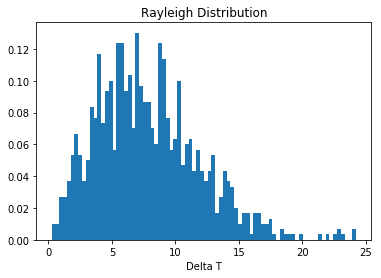

delta T values are:  [ 9.22963912  8.48975003 12.00364311  6.61766167  8.62383329  9.69155034
  8.5136183   8.29304838  6.32524847  7.12086888 13.31695925  6.22892423
  4.72381627  8.02140918 12.43823459  8.28607802  7.71710119  3.72241918
 10.83470755  8.34326975  0.90687952 12.05686327  5.66701806  4.14436522
  7.47002136  4.78033429 13.03500123  6.65083067 11.26122544  4.50147869]

 Tturb values are: [0, 9.22963912005872, 17.719389151121, 29.723032264616144, 36.3406939327631, 44.9645272187413, 54.6560775582399, 63.16969586022025, 71.46274423998834, 77.78799271239062, 84.90886159411023, 98.22582084298024, 104.45474507361831, 109.17856134565437, 117.19997052964901, 129.6382051169881, 137.92428313414064, 145.6413843209738, 149.3638035014717, 160.19851105380536, 168.5417808073093, 169.44866033218605, 181.50552359751762, 187.17254166023267, 191.3169068763614, 198.7869282317813, 203.56726252575902, 216.60226376063335, 223.25309442711298, 234.51431986568065]

 t values are: [8.859694575560

In [5]:
rayleighdistribution()

deltaT=fundeltaT(n_bins, n_samples)
print("delta T values are: ", deltaT)


Tturb=funTturb()
print("\n Tturb values are:", Tturb)

t=funt()
print("\n t values are:", t)

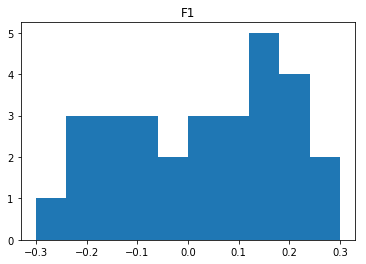

F1 values are [0.004274576319142409, 0.20958423989263913, 0.23647759351454484, 0.14927876973131787, 0.29472011775764306, 0.15060136860057471, 0.14684244535699564, 0.004339378642464142, 0.25423989384483314, -0.2633752187818628, 0.16770917774724997, -0.2100227873311897, -0.1636083877427032, 0.09087683754696996, -0.012200718571121705, 0.033983440145314736, -0.20397402371851345, 0.2051367528820089, -0.16738326059199604, 0.21757263751393166, -0.08871500687799563, -0.10997776316743649, -0.05627226884616776, -0.16092095105389134, -0.06368259386673339, -0.19442547260287985, 0.11427914096805158, 0.13057668871726053, 0.06150962867316834]


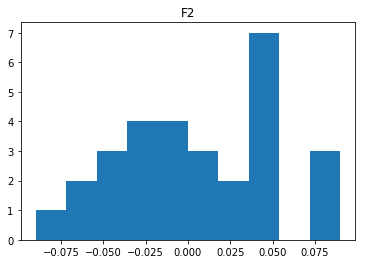

F2 values are [0.037035311934141016, 0.00451596679683991, 0.08719961594944321, -0.02179935981958516, 0.0489253373487836, -0.026463001172886906, -0.03240659404670562, -0.01708434313487467, -0.007353275734037684, -0.04185819728931939, -0.07328753393417618, 0.04428843013545826, 0.03950489918378762, 0.025696910718927005, 0.03830384299641579, -0.04919046285666504, -0.06323646853324993, 0.018374879591705487, -0.039889334154964484, -0.06434618382802804, 0.07831045585656107, 0.014875816167497904, -0.006224321713183517, -0.026309379933756358, 0.07630540826930489, 0.05133295736448605, 0.009002791378867475, 0.04411567262175678, -0.01297609140546957]


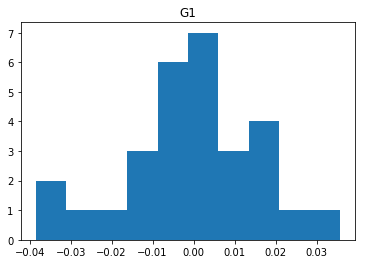

G1 values are  [0, 0.011586723550258955, 0.00131229384183497, -0.004682745103296539, 0.009542459480784795, -0.007868726754737388, -0.00020647560687873443, -0.008478960725108316, 0.017095049972614726, -0.03849550758740189, 0.021092475862633464, -0.019325397364332714, 0.004237697366896835, 0.01996710267445741, -0.0050380914384499185, 0.0022285013548013575, -0.014869386940600122, 0.03576293091525586, -0.025590215728069358, 0.020072810180495455, -0.03311164340966672, -0.001640171101319662, 0.0030301203967262012, -0.010666047715552721, 0.008372233573261594, -0.010672578207358037, 0.017328026916528304, 0.0008278820946392428, -0.0038558979292517073]


In [6]:
F1=funF1(meanF1, stdF1, Tr)
plt.hist(F1, 10, range=(-stdF1, stdF1))
plt.title("F1")
plt.show()
print("F1 values are", F1)

F2=funF2(meanF2, stdF2, Tr)
plt.hist(F2, 10, range=(-stdF2, stdF2))
plt.title("F2")
plt.show()
print("F2 values are", F2)

G1=funG1()
plt.hist(G1, 10)
plt.title("G1")
plt.show()
print("G1 values are ", G1)

### Amplitude of mode

Amplitude of mode for 30 eddy turnovers

 Average value of the amplitude squared = 0.07290896998085644


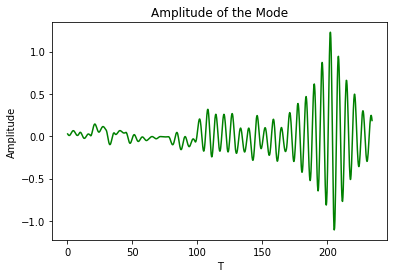

In [11]:
A, t =funAmp(dAdT, AT)
plt.plot(t, A, 'g')
plt.xlabel('T')
plt.ylabel('Amplitude')
plt.title('Amplitude of the Mode')

avg= FunavgA(A)

print("Amplitude of mode for" , n_samples, "eddy turnovers")
print("\n Average value of the amplitude squared =", avg)

### Check that derivative is correct for the first three eddies

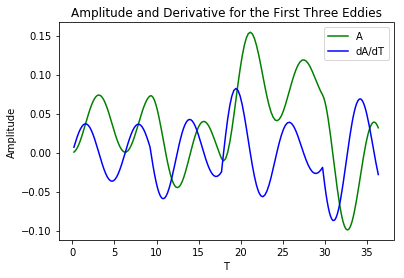

In [9]:
#FIRST EDDY TURNOVER
#check that derivative is correct

A=[]
t=[]
derivA=[]

dAdT=0
AT=0
## a**2<4*b is always the case
for i in range(4):
    a=F1[i]
    b=G1[i]+1
    c=F2[i]
    Ttemp=np.linspace(Tturb[i], Tturb[i+1])
    q=1/2*(4*b-a**2)**(1/2)
    C0=(math.exp(a*Tturb[i]/2)*dAdT+(a/2+q*math.tan(q*Tturb[i]))*(AT-c/b)*(math.exp(a*Tturb[i]/2)))*(math.cos(q*Tturb[i])/q)
    C1=(AT-c/b)*math.exp(a*Tturb[i]/2)/math.cos(q*Tturb[i])-C0*math.tan(q*Tturb[i])
    for j in Ttemp:
        if j==Tturb[i]:
            pass
        else:
            t.append(j)
            A.append(math.exp(-a*j/2)*(C0*math.sin(q*j)+C1*math.cos(q*j))+c/b)
            derivA.append(math.exp(-a*j/2)*(-a/2*(C0*math.sin(q*j)+C1*math.cos(q*j))+q*C0*math.cos(q*j)-q*C1*math.sin(q*j)))
    dAdT=derivA[-1]
    AT=A[-1]
    tend=t[-1]
    
plt.plot(t, A, 'g', label="A")
plt.plot(t, derivA, 'b', label="dA/dT")
plt.xlabel('T')
plt.ylabel('Amplitude')
plt.title('Amplitude and Derivative for the First Three Eddies')
plt.legend()